# Consensus Variant-to-Function Score for AD
### Authors: Ru Feng and Jenny Empawi

## Motivation
Systematically score and prioritize variants within AD loci using the consensus Variant-to-Function (CV2F) framework. Integrate the xQTL atlas with established functional annotations to improve the CV2F framework for AD.

## Implementation
Leverage 339 original CV2F features and augment with xQTL-specific features, including effect sizes and posterior inclusion probabilities (PIPs) from fine-mapping results. Train a gradient boosting model using AD fine-mapped credible sets and colocalization confidence intervals as positive controls, and non-AD associated variants as negative controls. Validate the framework performance with AUPRC metrics and demonstrate the added value of xQTL features.

## FunGen xQTL cv2f analysis

This notebook documents the process of **cv2f analysis**, which includes the following key steps:

Here the response would be GWAS signals only, and xQTL related information is in feature set. 

---

**1. Preparing the Feature Sets**

We aggregate the ALL feature sets from the v2g project by Fabiha, where each row represents a SNP–gene pair. For cv2f, we remove the gene information to obtain SNP-level features. The steps are:

- **Map variants to rsIDs** – Required for referencing minor allele frequencies (MAF).  
- **Retain SNP-only entries** – Extract unique SNPs and aggregate their features by taking the **maximum value across rows**.
- **Combine with cv2f feature sets**  - Keep **only** the variants that appear in the xQTL feature sets.
- No aggreagtion among different contexts in this feature set. 
- `exon` feature was removed because cv2f drops the first four columns. 
---

**2. Generating Positive and Negative Sets for cv2f**

**NOTE: We do not consider any xQTL dataset in those trainning datasets to avoid information linkage, no matter for positive or negative, and no matter from fine-mapping or colocalization**

We evaluated different thresholds when defining the positive feature sets but ultimately reported results using the following criteria.  
The threshold combinations we considered included:

- **Fine-mapping thresholds**
  - PIP > 0.9 with mappable CS size ≤ 3  
  - PIP > 0.7 with mappable CS size ≤ 10  
  - PIP > 0.6 with mappable CS size ≤ 10  
  - PIP > 0.7 with no CS size restriction (all variants in CS)

- **Colocalization from ColocBoost thresholds**
  - VCP > 0.9 with mappable CoS size ≤ 3  
  - VCP > 0.8 with mappable CoS size ≤ 10  
  - VCP > 0.6 with mappable CoS size ≤ 10  
  - VCP > 0.8 with no CoS size restriction (all variants in CoS)

**(1) Positive Set**
- Variants with **PIP > 0.7** in any **AD GWAS fine-mapping** analysis.  
- All variants within the **95% credible sets (CS)** from AD GWAS.  
- All variants within **CoS** and **uCoS** from **GWAS-only colocalization** results (no xQTL input).  

> Note: The criterion *“Variants with VCP > 0.8 from GWAS-only colocalization results”* is effectively redundant,  
> since including all variants within CoS and uCoS already encompasses all high-VCP variants from colocalization.

**(2) Negative Set**  
- Get **NON-NEGATIVE**: Identify variants from the 6 Alzheimer’s disease (AD) (no Jansen or Bellenguez_EDAI) contexts with **PIP > 0.025** (relaxed from the original 0.01 because of upstream finemapping analysis deafult), and those with **VCP > 0.01** from **GWAS-only colocalization**.  
- From the feature set, **exclude** variants in these NON-NEGATIVE AD-related sets and the positive set to define the negative set.

---

**3. Submit Jobs for cv2f Analysis**

The code is adapted from the [cv2f GitHub repository](https://github.com/Deylab999MSKCC/cv2f).

Minimal debugging edits are adapted to original script. These changes were primarily to address:

- Incorrect vector names  
- Errors caused by inconsistent column numbers across feature sets (as noted in Section 1)  
- Minor issues with file suffixes

---

**4. Visualization of Results**

## 1. Preparing the Feature Sets

### Reformat the feature sets
from Fabiha's v2g project to v2f, following the below format

```
head baseline.13.txt|cut -f 1-10
CHR	BP	SNP	CM	base	Coding_UCSC	Coding_UCSC.flanking.500Conserved_LindbladToh	Conserved_LindbladToh.flanking.500	CTCF_Hoffman
13	18445955	rs140871821	0.0	1	0	0	0	00
13	18446201	rs184229798	0.0	1	0	0	0	00
13	18446487	rs12018140	0.0	1	0	0	0	00
13	18446697	rs182776109	0.0	1	0	0	0	00
13	18446716	rs140166094	0.0	1	0	0	0	00
13	18446749	rs149988745	0.0	1	0	0	0	00
13	18446776	rs12017981	0.0	1	0	0	0	00
13	18446878	rs12381094	0.0	1	0	0	0	00
13	18446879	rs12381056	0.0	1	0	0	0	00
```

In [1]:
library(data.table)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday() 

In [2]:
snp_ref_path <- '/restricted/projectnb/xqtl/jaempawi/xqtl/00-All.variants.gz' #dnSNP database

### Load feature set data
I would use one chromosome to test the codes and prepare batch script and commands


In [3]:
chr=1

In [3]:
file_path = paste0('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2g/xqtl_feat.',chr,'.txt.gz')

In [6]:
feat_set <- fread(file_path)

In [65]:
feat_set %>% head

s2g,snp,gene_id,snp_bp,exon,s_in_g,same_tad,proximal_tad,g_closest_tss,single_context.Inh_mega_eQTL.PIP,⋯,trans.MSBB_eQTL_BM10.weight,EpiRaction.EPIraction_Brain_Alzheimer_Control_thresholded_predictions_0.026,ABC_dpfc,EpiMap,Baseline_Predss.dist_to_tss,Baseline_Predss.nearest_expressed_gene,EpiRaction.EPIraction_Brain_Alzheimer_Disease_thresholded_predictions_0.026,EpiRaction.EPIraction_Brain_Alzheimer_Encode_thresholded_predictions_0.026,xqtl_only_colocboost_export_filtered_MSBB.VCP,xqtl_only_colocboost_export_filtered_ROSMAP.VCP
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1:10000044_ENSG00000049239,chr1:10000044,ENSG00000049239,10000044,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1:10000044_ENSG00000054523,chr1:10000044,ENSG00000054523,10000044,0,0,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1:10000044_ENSG00000130939,chr1:10000044,ENSG00000130939,10000044,0,0,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1:10000044_ENSG00000130940,chr1:10000044,ENSG00000130940,10000044,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1:10000044_ENSG00000142583,chr1:10000044,ENSG00000142583,10000044,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1:10000044_ENSG00000142655,chr1:10000044,ENSG00000142655,10000044,0,0,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0


### NOTE: Different columns per chromosome

In practice, I found that only chromosome 1 has 269 columns, while the other chromosomes are missing 4 columns—all of which are trans-related. These trans features may have been too sparse and were likely removed earlier.

### Load rsid reference

In [5]:
# Run tabix command directly in shell via R
snp_ref <- system(paste("tabix ",snp_ref_path, chr), intern = TRUE)

# Show output
head(snp_ref)

ERROR: Error in system(paste("tabix ", snp_ref_path, chr), intern = TRUE): error in running command


In [67]:
# Use read.table with textConnection
snp_ref_df <- read.table(text = snp_ref, sep = "\t", header = FALSE,
                 col.names = c("chr", "start", "end", "rsid"))


In [68]:
snp_ref_df <- snp_ref_df %>% mutate(snp = paste0('chr',chr, ":", start))

In [69]:
snp_ref_df %>% head

,chr,start,end,rsid,snp
,<int>,<int>,<int>,<chr>,<chr>
1,1,10019,10020,rs775809821,chr1:10019
2,1,10039,10039,rs978760828,chr1:10039
3,1,10043,10043,rs1008829651,chr1:10043
4,1,10051,10051,rs1052373574,chr1:10051
5,1,10055,10056,rs768019142,chr1:10055
6,1,10055,10055,rs892501864,chr1:10055


### map rsid to chr_pos

In [70]:
feat_set %>% dim

[1] 21551170      269

In [71]:
feat_set_snp <- merge(feat_set, snp_ref_df, by = 'snp')

In [72]:
feat_set_snp %>% select(snp, rsid) %>% distinct %>% fwrite(.,
       paste0('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/xqtl_feature.var_list.', chr, '.txt.gz'), sep = '\t')
# save variant list as intermediate file for preparing pos and neg sets 

In [73]:
feat_set_snp <- feat_set_snp %>% select(chr, start, rsid, colnames(feat_set)[-c(1:4)]) %>% rename(CHR=chr, BP = start, SNP = rsid) 

In [74]:
# Save mapped feature set
fwrite(distinct(feat_set_snp),
       paste0('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/xqtl_feature.', chr, '.txt.gz'), sep = '\t')


In [7]:
agg_snp_max <- feat_set_snp %>% head %>% # add head here for quick check, would remove in script 
  group_by(SNP) %>%
  summarise(across(where(is.numeric), max, na.rm = TRUE)) %>% select(colnames(feat_set_snp))


In [14]:
impacted_cols <- feat_set_snp %>%
  select(where(is.numeric)) %>%
  colnames()
ncol(feat_set_snp)
length(impacted_cols)

[1] 267

[1] 266

That means all columns are aggregated except for the SNP ID column, which is as expected.

In [8]:
agg_snp_max

CHR,BP,SNP,exon,s_in_g,same_tad,proximal_tad,g_closest_tss,single_context.Inh_mega_eQTL.PIP,single_context.Inh_mega_eQTL.conditional_effect,⋯,trans.MSBB_eQTL_BM10.weight,EpiRaction.EPIraction_Brain_Alzheimer_Control_thresholded_predictions_0.026,ABC_dpfc,EpiMap,Baseline_Predss.dist_to_tss,Baseline_Predss.nearest_expressed_gene,EpiRaction.EPIraction_Brain_Alzheimer_Disease_thresholded_predictions_0.026,EpiRaction.EPIraction_Brain_Alzheimer_Encode_thresholded_predictions_0.026,xqtl_only_colocboost_export_filtered_MSBB.VCP,xqtl_only_colocboost_export_filtered_ROSMAP.VCP
<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
21,10006045,rs540071081,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
21,10009651,rs866528671,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
21,10001433,rs867788656,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [ ]:
fwrite(agg_snp_mean, paste0('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/xqtl_feat.',chr,'.txt.gz'))

aggreate above steps into R script and submit batch jobs:
```
#!/usr/bin/env Rscript

# Load required libraries
library(data.table)
library(tidyverse)

# Get chromosome from command line argument
args <- commandArgs(trailingOnly = TRUE)
chr <- as.integer(args[1])

# Define paths
snp_ref_path <- '/lila/data/deyk/ftp_fgc_xqtl/references/00-All.variants.gz'
file_path <- paste0('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2g/xqtl_feat.', chr, '.txt.gz')

# Load feature set data
feat_set <- fread(file_path)

# Load rsid reference using tabix
snp_ref <- system(paste("tabix", snp_ref_path, chr), intern = TRUE)
snp_ref_df <- read.table(text = snp_ref, sep = "\t", header = FALSE,
                         col.names = c("chr", "start", "end", "rsid")) %>%
  mutate(snp = paste0('chr', chr, ":", start))

# Map rsid to chr_pos
feat_set_snp <- merge(feat_set, snp_ref_df, by = 'snp') 
# feat_set_snp %>% select(snp, rsid) %>% distinct %>% fwrite(.,
#        paste0('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/xqtl_feature.var_list.', chr, '.txt.gz'), sep = '\t')

feat_set_snp <- feat_set_snp %>%
  select(chr, start, rsid, all_of(colnames(feat_set)[-c(1:4)])) %>%
  rename(CHR = chr, BP = start, SNP = rsid)

# Save mapped feature set
fwrite(distinct(feat_set_snp),
       paste0('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/xqtl_feature.', chr, '.txt.gz'), sep = '\t')

# Aggregate SNP max
agg_snp_max <- feat_set_snp %>%
  group_by(SNP) %>%
  summarise(across(where(is.numeric), max, na.rm = TRUE)) %>% 
  select(colnames(feat_set_snp))


# Save aggregated feature set
fwrite(agg_snp_max,
       paste0('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max/xqtl_feature_max.', chr, '.txt.gz'), sep = '\t')
```

In [ ]:
#!/bin/bash

for chr in {1..22}; do
  bsub -q cpuqueue -n 1 -M 200GB -W 10:00 \
    -o /home/fengr1/Work/v2f/logs/aggfeat_chr${chr}.out -e /home/fengr1/Work/v2f/logs/aggfeat_chr${chr}.err \
    "Rscript ~/Work/v2f/analysis/aggregate_xqtl_features.R ${chr}"
done

### Combine with cv2f feature sets

In [ ]:
library(tidyverse)
library(data.table)
setwd('~/deyk/ru/Work/v2f/analysis')
cv2f_files <- list.files("/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/cv2f_features/cv2f_features/", full.names = T)
agg_xqtl_files <- list.files("/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max/", full.names = T)
#### Main loop #### 

for(i in 1:22){
  cat(i)
  cv2f <- fread(paste0('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/cv2f_features/cv2f_features/baseline_annotation_chrmbpnet.', i, '.txt'))
  s2g <- fread(paste0('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max//xqtl_feature_max.', i, '.txt.gz'))
  
  #### add cv2f feature #### 
  
  # Extract cv2f features (skip first 4 columns)
  cv2f_features <- colnames(cv2f)[5:ncol(cv2f)]
  
  # Create snp column
  cv2f <- cv2f %>%
    mutate(snp = paste0("chr", CHR, ":", BP))
  # Merge s2g with cv2f features
  s2g <- s2g %>%
    mutate(snp = paste0("chr", CHR, ":", BP)) %>%
    left_join(cv2f %>% select(all_of(cv2f_features), snp), by = "snp") %>%
    mutate(across(all_of(cv2f_features), ~replace_na(., 0))) %>% select(-snp)
  
  fwrite(s2g, paste0('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_allcv2f/xqtl_feature_max_allcv2f.', i, '.txt.gz'), sep = '\t')
}


#### check feature sets

In [4]:
feat_tmp <- fread('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_allcv2f/xqtl_feature_max_allcv2f.22.txt.gz') # xqtl plus all feature from cv2f paper

In [5]:
feat_tmp %>% colnames

[1] "CHR"                                                                        
  [2] "BP"                                                                         
  [3] "SNP"                                                                        
  [4] "exon"                                                                       
  [5] "s_in_g"                                                                     
  [6] "same_tad"                                                                   
  [7] "proximal_tad"                                                               
  [8] "g_closest_tss"                                                              
  [9] "single_context.Inh_mega_eQTL.PIP"                                           
 [10] "single_context.Inh_mega_eQTL.conditional_effect"                            
 [11] "single_context.Inh_mega_eQTL.weight"                                        
 [12] "single_context.Inh_Kellis_eQTL.PIP"                                         
 [13] "single_context.Inh_Kellis_eQTL.conditional_effect"                          
 [14] "single_context.Inh_Kellis_eQTL.weight"                                      
 [15] "single_context.ROSMAP_PCC_sQTL.PIP"                                         
 [16] "single_context.ROSMAP_PCC_sQTL.conditional_effect"                          
 [17] "single_context.ROSMAP_PCC_sQTL.weight"                                      
 [18] "single_context.MiGA_GTS_eQTL.PIP"                                           
 [19] "single_context.MiGA_GTS_eQTL.conditional_effect"                            
 [20] "single_context.MiGA_GTS_eQTL.weight"                                        
 [21] "single_context.monocyte_ROSMAP_eQTL.PIP"                                    
 [22] "single_context.monocyte_ROSMAP_eQTL.conditional_effect"                     
 [23] "single_context.monocyte_ROSMAP_eQTL.weight"                                 
 [24] "single_context.Ast_DeJager_eQTL.PIP"                                        
 [25] "single_context.Ast_DeJager_eQTL.conditional_effect"                         
 [26] "single_context.Ast_DeJager_eQTL.weight"                                     
 [27] "single_context.Ast_mega_eQTL.PIP"                                           
 [28] "single_context.Ast_mega_eQTL.conditional_effect"                            
 [29] "single_context.Ast_mega_eQTL.weight"                                        
 [30] "single_context.BM_10_MSBB_eQTL.PIP"                                         
 [31] "single_context.BM_10_MSBB_eQTL.conditional_effect"                          
 [32] "single_context.BM_10_MSBB_eQTL.weight"                                      
 [33] "single_context.Mic_DeJager_eQTL.PIP"                                        
 [34] "single_context.Mic_DeJager_eQTL.conditional_effect"                         
 [35] "single_context.Mic_DeJager_eQTL.weight"                                     
 [36] "single_context.Knight_pQTL_brain.PIP"                                       
 [37] "single_context.Knight_pQTL_brain.conditional_effect"                        
 [38] "single_context.Knight_pQTL_brain.weight"                                    
 [39] "single_context.STARNET_eQTL_Mac.PIP"                                        
 [40] "single_context.STARNET_eQTL_Mac.conditional_effect"                         
 [41] "single_context.STARNET_eQTL_Mac.weight"                                     
 [42] "single_context.DLPFC_Klein_gpQTL_adjusted.PIP"                              
 [43] "single_context.DLPFC_Klein_gpQTL_adjusted.conditional_effect"               
 [44] "single_context.DLPFC_Klein_gpQTL_adjusted.weight"                           
 [45] "single_context.MiGA_SVZ_eQTL.PIP"                                           
 [46] "single_context.MiGA_SVZ_eQTL.conditional_effect"                            
 [47] "single_context.MiGA_SVZ_eQTL.weight"                                        
 [48] "single_context.BM_36_MSBB_eQTL.PIP"            

In [6]:
dim(feat_tmp) ## chrom 22

[1] 236695    603

In [7]:
subset_feat_tmp <- fread('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_cv2f/xqtl_feature_max_cv2f.22.txt.gz') # xqtl plus subset features from cv2f paper only using brain related feature

In [8]:
dim(subset_feat_tmp) ## chrom 22

[1] 236695    283

In [11]:
setdiff(colnames(subset_feat_tmp), colnames(feat_tmp)) %>% length

[1] 0

In [10]:
setdiff(colnames(feat_tmp), colnames(subset_feat_tmp)) %>% length

[1] 320

## 2. Generating Positive and Negative Sets

In [1]:
library(data.table)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday() 

In [2]:
fmp_paths <- list.files('/home/fengr1/fungen_xQTL/', 'toploci.bed.gz$', full.names = T, recursive = T)

### generate variant list from feature set 

In [3]:
# var_paths <- list.files('/home/fengr1/v2f_data/xqtl_features/xqtl_features_v2f', 'var_list', full.names = T) # the intermediate files from last step
# var_paths %>% length

# var_list <- data.frame()
# for(var_path in var_paths){
#     var_list <- rbind(var_list, fread(var_path))
# }
# fwrite(var_list, '/home/fengr1/v2f_data/xqtl_features/xqtl_features_v2f/variant_list.txt.gz', sep = '\t')

In [4]:
var_list <- fread('/home/fengr1/v2f_data/xqtl_features/xqtl_features_v2f/variant_list.txt.gz', sep = '\t')

In [5]:
var_list %>% head

snp,rsid
<chr>,<chr>
chr1:10000044,rs112409036
chr1:100000723,rs11166389
chr1:100000839,rs116740877
chr1:100000874,rs550182761
chr1:100000874,rs549210756
chr1:100000874,rs796619774


In [6]:
var_list %>% dim

[1] 16194875        2

### positive set

#### Define parameter sets

In [2]:
param_list <- list(
  strict = list(PIP = 0.9, VCP = 0.9, CS_size = 3, CoS_size = 3),
  intermediate = list(PIP = 0.7, VCP = 0.8, CS_size = 10, CoS_size = 10),
  loose = list(PIP = 0.6, VCP = 0.6, CS_size = 10, CoS_size = 10),
  superloose = list(PIP = 0.6, VCP = 0.6, CS_size = 0, CoS_size = 0)

)

In [ ]:
fmp_paths <- list.files('~/ftp_fgc_xqtl/fungen_xQTL/', 'toploci.bed.gz$', full.names = T, recursive = T)


In [ ]:
### File paths
AD_fmp_paths <- file_paths %>% .[str_detect(., 'GWAS')] %>% .[!str_detect(., '_Jansen|_EADI')]
AD_cb_paths <- c("/data/deyk/ftp_fgc_xqtl/fungen_xQTL/colocboost/ad_meta_colocboost_export_filtered.bed")

In [ ]:
### Function: process fine-mapping
process_finemapping <- function(paths, pip_threshold, cs_size_threshold) {
  fmp_positive <- data.frame()
  for (path in paths) {
    dat <- fread(path)
    if (!all(c("gene_ID", "event_ID", "cs_coverage_0.95") %in% colnames(dat))) next
    dat_cs <- dat %>%
      filter(cs_coverage_0.95 > 0) %>%
      mutate(cs_id = paste0(gene_ID, event_ID, cs_coverage_0.95))
    
    dat_map <- dat_cs %>%
      group_by(cs_id) %>%
      summarise(cs_size = n_distinct(variant_ID), .groups = "drop")
    
    # Only filter cs_size if threshold > 0
    if (cs_size_threshold > 0) {
      dat_map <- dat_map %>% filter(cs_size <= cs_size_threshold)
    }
    
    dat_map <- dat_map %>%
      left_join(dat_cs, by = "cs_id") %>%
      mutate(category = 'Mappable')
    
    dat_pip <- dat %>% filter(PIP > pip_threshold) %>% mutate(category = 'PIP')
    
    pos <- rbind(dat_pip,
                 dat_map %>% select(-cs_id, -cs_size))
    fmp_positive <- plyr::rbind.fill(fmp_positive, pos)
  }
  cat("Positive set from fine-mapping mappable sets:", 
      fmp_positive %>% filter(category == 'Mappable') %>% pull(variant_ID) %>% unique %>% length, "\n")
  cat("Positive set from fine-mapping high PIP:", 
      fmp_positive %>% filter(category == 'PIP') %>% pull(variant_ID) %>% unique %>% length, "\n")
  return(fmp_positive)
}


### Function: process colocboost
process_coloc <- function(paths, vcp_threshold, cos_size_threshold) {
  cb_positive <- data.frame()
  for (path in paths) {
    dat <- fread(path)
    dat_map <- dat %>%
      group_by(cos_ID) %>%
      summarise(cos_size = n_distinct(variant_ID), .groups = "drop")
    
    # Only filter cos_size if threshold > 0
    if (cos_size_threshold > 0) {
      dat_map <- dat_map %>% filter(cos_size <= cos_size_threshold)
    }
    
    dat_map <- dat_map %>%
      left_join(dat, by = "cos_ID") %>%
      mutate(category = 'Mappable')
    
    dat_vcp <- dat %>% filter(vcp > vcp_threshold) %>% mutate(category = 'VCP')
    
    pos <- rbind(dat_vcp,
                 dat_map %>% select(-cos_size))
    cb_positive <- plyr::rbind.fill(cb_positive, pos)
    
    cat("Positive set from colocboost mappable sets:", 
        cb_positive %>% filter(category == 'Mappable') %>% pull(variant_ID) %>% unique %>% length, "\n")
    cat("Positive set from colocboost high VCP:", 
        cb_positive %>% filter(category == 'VCP') %>% pull(variant_ID) %>% unique %>% length, "\n")
  }
  return(cb_positive)
}


### Function: extract non-negative
extract_non_negative <- function(fmp_paths, cb_paths) {
  nonneg <- data.frame()
  for (path in fmp_paths) {
    dat <- fread(path)
    if ("PIP" %in% colnames(dat))
      nonneg <- plyr::rbind.fill(nonneg, dat %>% filter(PIP >= 0.01) %>% mutate(category = 'Fine-mapping'))
  }
  cat("NON-Negative set from fine-maping:", 
      nonneg %>% filter(category == 'Fine-mapping') %>% pull(variant_ID) %>% unique %>% length, "\n")
  
  for (path in cb_paths) {
    dat <- fread(path)
    if ("vcp" %in% colnames(dat))
      nonneg <- plyr::rbind.fill(nonneg, dat %>% filter(vcp >= 0.01) %>% mutate(category = 'colocboost'))
  }
  cat("NON-Negative set from colocboost:", 
      nonneg %>% filter(category == 'colocboost') %>% pull(variant_ID) %>% unique %>% length, "\n")
  
  return(nonneg)
}

In [135]:
### Run all parameter sets
for (label in names(param_list)) {
  param <- param_list[[label]]
  message("Processing: Postive fine-mapping PIP as ", param$PIP, " & mappble cs size as ", param$CS_size, "; ColocBoost VCP as ", param$VCP, " & mappable cos size as ", param$CoS_size, "\n")
  status_name <- paste0("PIP", param$PIP, "_CS", param$CS_size, "_VCP", param$VCP, "_COS", param$CoS_size)
    
  # Positive set
  fmp_positive <- process_finemapping(AD_fmp_paths, param$PIP, param$CS_size)
  cb_positive <- process_coloc(AD_cb_paths, param$VCP, param$CoS_size)
  positive <- plyr::rbind.fill(fmp_positive, cb_positive)
  fwrite(positive, paste0('~/Work/v2f/results/posneg_process/positive.', status_name, '.df.csv.gz'))

  # RSID for positive
  positive_rs <- positive %>%
    mutate(snp = paste0("chr", `#chr`, ":", end)) %>%
    merge(var_list)
  writeLines(unique(positive_rs$rsid),
             paste0('~/Work/v2f/results/posneg_process/positive_set.', status_name, '.txt'))

  # Non-negative: includes positive + PIP ≥ 0.01 or VCP ≥ 0.01
  non_negative <- extract_non_negative(AD_fmp_paths, AD_cb_paths)
  non_negative <- plyr::rbind.fill(non_negative, positive) # actually not necessary that the non_negative must contain positive set by PIP or VCP
  fwrite(non_negative, paste0('~/Work/v2f/results/posneg_process/non_negative.', status_name, '.df.csv.gz'))

  # RSID for non-negative
  non_negative_rs <- non_negative %>%
    mutate(snp = paste0("chr", `#chr`, ":", end)) %>%
    merge(var_list)

  # Negative set
  negative_rs <- setdiff(var_list$rsid, non_negative_rs$rsid)
  writeLines(negative_rs,
             paste0('~/Work/v2f/results/posneg_process/negative_set.', status_name, '.txt'))
    cat("=== Summary for", label, "set ===\n")
    cat("Positive set (variants):", length(unique(positive$variant_ID)), "\n")
    cat("Positive set (intersected with feature set):**", length(unique(positive_rs$rsid)), "**\n")
    cat("NON-Negative set (finemapping + colocboost + positive):", length(unique(non_negative$variant_ID)), "\n")
    cat("NON-Negative set (intersected with feature set):", length(unique(non_negative_rs$rsid)), "\n")
    cat("Negative set (intersected with feature set):**", length(negative_rs), "**\n\n")
}

Processing: Postive fine-mapping PIP as 0.9 & mappble cs size as 3; ColocBoost VCP as 0.9 & mappable cos size as 3




Positive set from fine-mapping mappable sets: 57 
Positive set from fine-mapping high PIP: 28 
Positive set from colocboost mappable sets: 45 
Positive set from colocboost high VCP: 17 
NON-Negative set from fine-maping: 3490 
NON-Negative set from colocboost: 880 
=== Summary for strict set ===
Positive set (variants): 79 
Positive set (intersected with feature set):** 52 **
NON-Negative set (finemapping + colocboost + positive): 3633 
NON-Negative set (intersected with feature set): 3389 
Negative set (intersected with feature set):** 16191486 **



Processing: Postive fine-mapping PIP as 0.7 & mappble cs size as 10; ColocBoost VCP as 0.8 & mappable cos size as 10




Positive set from fine-mapping mappable sets: 200 
Positive set from fine-mapping high PIP: 48 
Positive set from colocboost mappable sets: 146 
Positive set from colocboost high VCP: 20 
NON-Negative set from fine-maping: 3490 
NON-Negative set from colocboost: 880 
=== Summary for intermediate set ===
Positive set (variants): 277 
Positive set (intersected with feature set):** 212 **
NON-Negative set (finemapping + colocboost + positive): 3643 
NON-Negative set (intersected with feature set): 3389 
Negative set (intersected with feature set):** 16191486 **



Processing: Postive fine-mapping PIP as 0.6 & mappble cs size as 10; ColocBoost VCP as 0.6 & mappable cos size as 10




Positive set from fine-mapping mappable sets: 200 
Positive set from fine-mapping high PIP: 59 
Positive set from colocboost mappable sets: 146 
Positive set from colocboost high VCP: 28 
NON-Negative set from fine-maping: 3490 
NON-Negative set from colocboost: 880 
=== Summary for loose set ===
Positive set (variants): 284 
Positive set (intersected with feature set):** 219 **
NON-Negative set (finemapping + colocboost + positive): 3643 
NON-Negative set (intersected with feature set): 3389 
Negative set (intersected with feature set):** 16191486 **



Additionally check the set of super loose set only, which is new and generated in R studio;

copy and paste the output information from Rstudio, so I don't have to cover the exsiting information above

```
Processing: Positive fine-mapping PIP as 0.7 & mappable cs size as 0; ColocBoost VCP as 0.8 & mappable cos size as 0

Positive set from fine-mapping mappable sets: 1817 
Positive set from fine-mapping high PIP: 48 
Positive set from colocboost mappable sets: 5212 
Positive set from colocboost high VCP: 20 
NON-Negative set from fine-maping: 3490 
NON-Negative set from colocboost: 880 
=== Summary for intermediate set ===
Positive set (variants): 5798 
Positive set (intersected with feature set):** 1787 **
NON-Negative set (finemapping + colocboost + positive): 7755 
NON-Negative set (intersected with feature set): 4150 
Negative set (intersected with feature set):** 16190725 **
```

## 3. Submit Jobs for cv2f Analysis


In [ ]:
#!/bin/bash

# Parameter sets
param_sets=(
  "PIP0.7_CS0_VCP0.8_COS0"
  "PIP0.7_CS10_VCP0.8_COS10"
  "PIP0.9_CS3_VCP0.9_COS3"
  "PIP0.6_CS10_VCP0.6_COS10"
)

# Feature sets
feature_sets=(
  "/lila/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_allcv2f/xqtl_feature_max_allcv2f."
)

# Shared input files
bimpath="/home/fengr1/deyk/ftp_fgc_xqtl/v2f/1000G_BIMS_hg38/1000G.EUR.QC."
mafpath="/data/deyk/extras/MAF_features_Aug032022.txt"
ldblockspath="/home/fengr1/deyk/ftp_fgc_xqtl/v2f/LAVA_LDblocks_published.txt"

# Create directories
mkdir -p /home/fengr1/Work/v2f/results/score/FunGen_xQTL
mkdir -p /home/fengr1/Work/v2f/results/metric/FunGen_xQTL
mkdir -p /home/fengr1/Work/v2f/logs

for status in "${param_sets[@]}"; do
  for feat in "${feature_sets[@]}"; do
    feat_label=$(basename ${feat%.*})
    mkdir -p /home/fengr1/Work/v2f/results/score/FunGen_xQTL/${status}/${feat_label}
    mkdir -p /home/fengr1/Work/v2f/results/metric/FunGen_xQTL/${status}/${feat_label}

    positive_set="/lila/data/deyk/ru/Work/v2f/results/posneg_process/positive_set.${status}.txt"
    negative_set="/lila/data/deyk/ru/Work/v2f/results/posneg_process/negative_set.${status}.txt"
    output_metrics="/home/fengr1/Work/v2f/results/metric/FunGen_xQTL/${status}/${feat_label}/FunGen_xQTL.${status}.${feat_label}.metrics"

    echo ">>> Running metrics: $status with $feat_label"
    Rscript /lila/home/fengr1/codes/cv2f/metric/run_cv2f_MAF5LDmatch_metrics.R \
      --positive_set $positive_set \
      --negative_set $negative_set \
      --feature_file $feat \
      --bimpath $bimpath \
      --mafpath $mafpath \
      --ldblockspath $ldblockspath \
      --output_metrics $output_metrics > /home/fengr1/Work/v2f/logs/xqtl_metric.${status}.${feat_label}.log 2>&1

    for chrm in {1..22}; do
      output_cv2f="/home/fengr1/Work/v2f/results/score/FunGen_xQTL/${status}/${feat_label}/FunGen_xQTL.${status}.${feat_label}.chr${chrm}.cv2f"

      echo ">>> Running score: $status, $feat_label, chr${chrm}"
      Rscript /lila/home/fengr1/codes/cv2f/score/run_cv2f_MAF5LDmatch_cv2f_scores.R \
        --positive_set $positive_set \
        --negative_set $negative_set \
        --feature_file $feat \
        --bimpath $bimpath \
        --mafpath $mafpath \
        --ldblockspath $ldblockspath \
        --output_cv2f $output_cv2f \
        --chrm $chrm > /home/fengr1/Work/v2f/logs/xqtl_score.${status}.${feat_label}.chr${chrm}.log 2>&1
    done
  done
done

#### Check the time stamp of input files

```
ls positive_set.* -hl
-rw-r--r-- 1 fengr1 deyk 2.3K Jul 25 15:41 positive_set.PIP0.6_CS10_VCP0.6_COS10.txt
-rw-r--r-- 1 fengr1 deyk  19K Jul 29 10:26 positive_set.PIP0.7_CS0_VCP0.8_COS0.txt
-rw-r--r-- 1 fengr1 deyk 2.3K Jul 25 15:41 positive_set.PIP0.7_CS10_VCP0.8_COS10.txt
-rw-r--r-- 1 fengr1 deyk  560 Jul 25 15:40 positive_set.PIP0.9_CS3_VCP0.9_COS3.txt

ls negative_set.* -hl
-rw-r--r-- 1 fengr1 deyk 174M Jul 25 15:41 negative_set.PIP0.6_CS10_VCP0.6_COS10.txt
-rw-r--r-- 1 fengr1 deyk 174M Jul 29 10:27 negative_set.PIP0.7_CS0_VCP0.8_COS0.txt
-rw-r--r-- 1 fengr1 deyk 174M Jul 25 15:41 negative_set.PIP0.7_CS10_VCP0.8_COS10.txt
-rw-r--r-- 1 fengr1 deyk 174M Jul 25 15:41 negative_set.PIP0.9_CS3_VCP0.9_COS3.txt
```

```
ls -hl /data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_allcv2f/*
-rw-r--r-- 1 fengr1 deyk 51M Jul 28 21:20 /data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_allcv2f/xqtl_feature_max_allcv2f.10.txt.gz
-rw-r--r-- 1 fengr1 deyk 50M Jul 28 21:20 /data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_allcv2f/xqtl_feature_max_allcv2f.11.txt.gz
-rw-r--r-- 1 fengr1 deyk 50M Jul 28 21:21 /data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_allcv2f/xqtl_feature_max_allcv2f.12.txt.gz
-rw-r--r-- 1 fengr1 deyk 33M Jul 28 21:21 /data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_allcv2f/xqtl_feature_max_allcv2f.13.txt.gz

```

## 4. Visualization of Results

```
ls */xqtl_feature_max_cv2f/*metrics -hl
-rw-r--r-- 1 fengr1 deyk 116 Jul 29 17:01 PIP0.7_CS0_VCP0.8_COS0/xqtl_feature_max_cv2f/FunGen_xQTL.PIP0.7_CS0_VCP0.8_COS0.xqtl_feature_max_allcv2f.metrics
-rw-r--r-- 1 fengr1 deyk 113 Jul 29 15:10 PIP0.7_CS10_VCP0.8_COS10/xqtl_feature_max_cv2f/FunGen_xQTL.PIP0.7_CS10_VCP0.8_COS10.xqtl_feature_max_allcv2f.metrics
-rw-r--r-- 1 fengr1 deyk  52 Jul 28 23:27 PIP0.9_CS3_VCP0.9_COS3/xqtl_feature_max_cv2f/FunGen_xQTL.PIP0.9_CS3_VCP0.9_COS3.xqtl_feature_max_allcv2f.metrics
```

In [10]:
library(data.table)
library(ggplot2)
library(dplyr)
library(stringr)

# Define statuses (adjust to match your naming scheme)
status <- c("PIP0.7_CS0_VCP0.8_COS0")

# Output folder for plots
plot_dir <- "/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_cv2f/metric" #FIXME
dir.create(plot_dir, recursive = TRUE, showWarnings = FALSE)
metric_list = figure_list = list()

for (status in statuses) {
  message("Processing status: ", status)
  
  ### Load metrics
  metric_file <- paste0(plot_dir, "/xqtl_feature_max_allcv2f/FunGen_xQTL.", status, ".xqtl_feature_max_allcv2f.metrics")  #FIXME
  shap_file   <- paste0(plot_dir, "/xqtl_feature_max_allcv2f/FunGen_xQTL.", status, ".xqtl_feature_max_allcv2f.shap_values.csv")   #FIXME
  
  if (!file.exists(metric_file) | !file.exists(shap_file)) {
    warning("Missing file(s) for status: ", status)
    next
  }
  
  metric_list[[status]] <- fread(metric_file)
  shap_dt <- fread(shap_file)
  
  ### Aggregate SHAP values
  shap_summary <- shap_dt[, .(
    mean_abs_rfvalue = mean(abs(rfvalue)),
    max_rfvalue = max(abs(rfvalue)),
    n = .N
  ), by = variable] %>% 
    arrange(desc(mean_abs_rfvalue))
  
  ### Plot: Top 20 Features
  figure_list[[status]]$p1 <- ggplot(shap_summary[1:20], aes(x = reorder(variable, mean_abs_rfvalue), y = mean_abs_rfvalue)) +
    geom_col() +
    coord_flip() +
    labs(title = paste("Top 20 Features by Mean |SHAP| -", status),
         x = "Feature", y = "Mean |SHAP| Value") +
    theme_minimal()
  
  # ggsave(filename = paste0(plot_dir, "Top20_SHAP_", status, ".png"), plot = p1, width = 10, height = 6)
  
  ### Plot: Top 20 Non-dominant Non-sQTL Features
  figure_list[[status]]$p2 <- shap_summary %>%
    slice(-(1:4)) %>% 
    filter(!str_detect(variable, "sQTL")) %>% 
    slice_max(order_by = mean_abs_rfvalue, n = 20) %>%
    ggplot(aes(x = reorder(variable, mean_abs_rfvalue), y = mean_abs_rfvalue)) +
    geom_col() +
    coord_flip() +
    labs(title = paste("Top 20 Non-dominant Non-sQTL Features -", status),
         x = "Feature", y = "Mean |SHAP| Value") +
    theme_minimal()
  
  # ggsave(filename = paste0(plot_dir, "Top20_NonSQTLSHAP_", status, ".png"), plot = p2, width = 10, height = 6)

}
     

Processing status: PIP0.7_CS0_VCP0.8_COS0



### PIP0.7_CS0_VCP0.8_COS0

In [11]:
metric_list$PIP0.7_CS0_VCP0.8_COS0

AUROC.mean,AUROC.sd,AUPRC.mean,AUPRC.sd
<dbl>,<dbl>,<dbl>,<dbl>
0.9181583,0.01473063,0.9244869,0.01402415


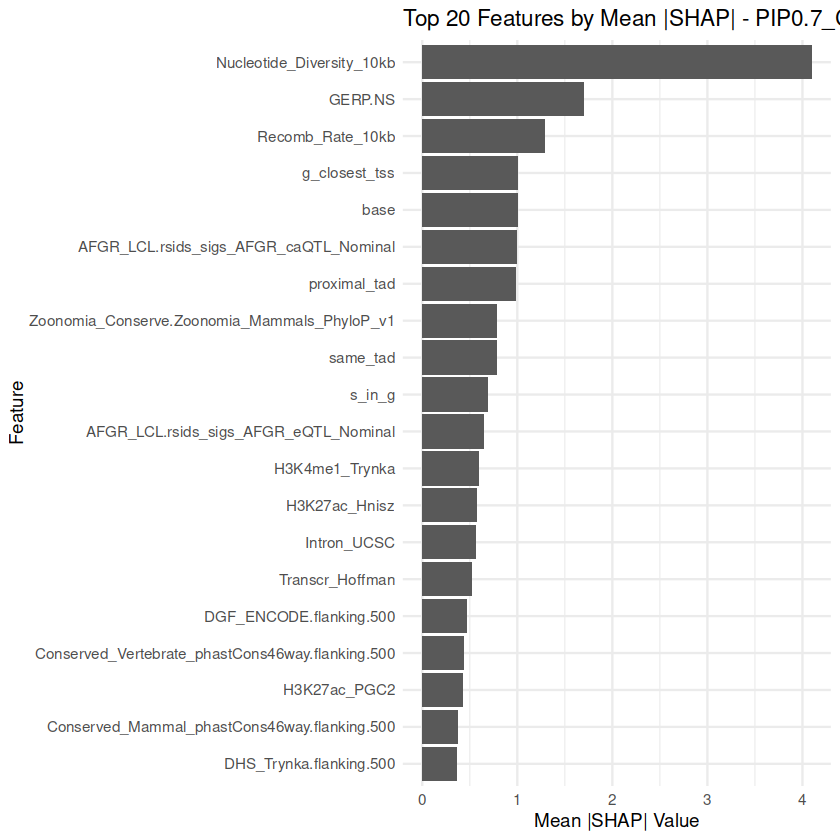

In [12]:
figure_list$PIP0.7_CS0_VCP0.8_COS0$p1

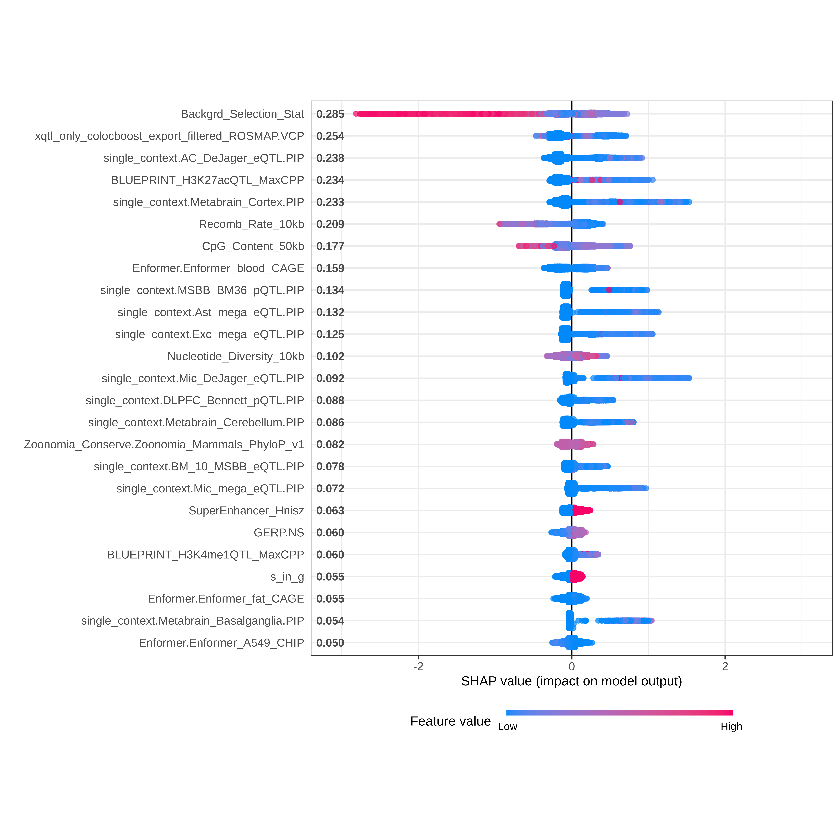

In [13]:
library(png)
library(grid)

img <- readPNG("/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_cv2f/metric/xqtl_feature_max_allcv2f/FunGen_xQTL.PIP0.7_CS0_VCP0.8_COS0.xqtl_feature_max_allcv2f.png") #FIXME
grid.raster(img)

## (Optional) Experiment

### Additional Experiment (Suggestion from Gao)

As suggested by Gao, a valuable experiment to strengthen our findings is to assess model performance when excluding all xQTL features.  
Specifically, we would train the model on the same positive and negative sets described above  
(using **PIP > 0.7 with no CS size restriction** and **VCP > 0.8 with no CoS size restriction**).  

In this setting, the feature set would consist only of Fabiha’s annotations, without any xQTL-derived features.  
This approach mirrors strategies used in prior studies, where sources of annotation were systematically removed to evaluate their individual contributions. 

We anticipate a similar outcome here: removing xQTL features is expected to substantially reduce the AUC compared to the full model,  
thereby highlighting the unique and critical contribution of xQTL information.

experiment by taking out xQTL information from feature sets to check AUC

### prepare new feature sets without xQTL

In [1]:
library(tidyverse)
library(data.table)
setwd('~/deyk/ru/Work/v2f/analysis')
# cv2f_files <- list.files("/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/cv2f_features/cv2f_features/", full.names = T)
# agg_xqtl_files <- list.files("/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max/", full.names = T)


#### Main loop #### 

for(i in 1:22){
  cat(i)
  cv2f <- fread(paste0('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/cv2f_features/cv2f_features/baseline_annotation_chrmbpnet.', i, '.txt'))
  s2g <- fread(paste0('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max//xqtl_feature_max.', i, '.txt.gz'))
  
  #### add cv2f feature #### 
  
  # Extract cv2f features (skip first 4 columns)
  cv2f_features <- colnames(cv2f)[5:ncol(cv2f)]
  
  # Create snp column
  cv2f <- cv2f %>%
    mutate(snp = paste0("chr", CHR, ":", BP))
  # Merge s2g with cv2f features
  s2g <- s2g %>%
    mutate(snp = paste0("chr", CHR, ":", BP)) %>%
    left_join(cv2f %>% select(all_of(cv2f_features), snp), by = "snp") %>%
    mutate(across(all_of(cv2f_features), ~replace_na(., 0))) %>% select(-snp)
  s2g_xqtl_elements <- colnames(s2g) %>% .[str_detect(., 'QTL|qtl|Metabrain|single_context|multi_context')]
  # remove all xqtl feature
  s2g_noxqtl <- s2g %>%
    select(-any_of(s2g_xqtl_elements)) 
  # s2g_noxqtl %>% mutate(snp=paste0('chr', CHR, ':', BP), rsid=SNP) %>% select(snp, rsid) %>% 
  #   fwrite(paste0('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/agg_snp_max_allcv2f_noxqtl/var_list.', i, '.txt'), sep = '\t')
  fwrite(s2g_noxqtl, paste0('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_allcv2f_noxqtl/xqtl_feature_max_allcv2f_noxqtl.', i, '.txt.gz'), sep = '\t')
   ## the difference with v2f/xqtl_features/no_xqtl_features_v2f is this does not remain the variants in cv2f only and that one does
}



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




1

Warning message in left_join(., cv2f %>% select(all_of(cv2f_features), snp), by = "snp"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 213138 of `x` matches multiple rows in `y`.
ℹ Row 631086 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


23

Warning message in left_join(., cv2f %>% select(all_of(cv2f_features), snp), by = "snp"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 769626 of `x` matches multiple rows in `y`.
ℹ Row 36549 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


456

Warning message in left_join(., cv2f %>% select(all_of(cv2f_features), snp), by = "snp"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 305543 of `x` matches multiple rows in `y`.
ℹ Row 229009 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


7

Warning message in left_join(., cv2f %>% select(all_of(cv2f_features), snp), by = "snp"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 198030 of `x` matches multiple rows in `y`.
ℹ Row 328203 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


8

Warning message in left_join(., cv2f %>% select(all_of(cv2f_features), snp), by = "snp"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 477267 of `x` matches multiple rows in `y`.
ℹ Row 383828 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


9

Warning message in left_join(., cv2f %>% select(all_of(cv2f_features), snp), by = "snp"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 162469 of `x` matches multiple rows in `y`.
ℹ Row 113111 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


10

Warning message in left_join(., cv2f %>% select(all_of(cv2f_features), snp), by = "snp"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 183338 of `x` matches multiple rows in `y`.
ℹ Row 150368 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


11

Warning message in left_join(., cv2f %>% select(all_of(cv2f_features), snp), by = "snp"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 164173 of `x` matches multiple rows in `y`.
ℹ Row 142465 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


1213141516171819

Warning message in left_join(., cv2f %>% select(all_of(cv2f_features), snp), by = "snp"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 8572 of `x` matches multiple rows in `y`.
ℹ Row 87830 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


202122

#### check new feature sets

In [1]:
feat_tmp <- fread('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_allcv2f_noxqtl/xqtl_feature_max_allcv2f_noxqtl.22.txt.gz')

ERROR: Error in fread("/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_allcv2f_noxqtl/xqtl_feature_max_allcv2f_noxqtl.22.txt.gz"): could not find function "fread"


In [ ]:
feat_tmp$exon %>% head

In [4]:
feat_tmp %>% colnames

[1] "CHR"                                                                        
  [2] "BP"                                                                         
  [3] "SNP"                                                                        
  [4] "exon"                                                                       
  [5] "s_in_g"                                                                     
  [6] "same_tad"                                                                   
  [7] "proximal_tad"                                                               
  [8] "g_closest_tss"                                                              
  [9] "EpiRaction.EPIraction_Brain_Alzheimer_Control_thresholded_predictions_0.026"
 [10] "ABC_dpfc"                                                                   
 [11] "EpiMap"                                                                     
 [12] "Baseline_Predss.dist_to_tss"                                                
 [13] "Baseline_Predss.nearest_expressed_gene"                                     
 [14] "EpiRaction.EPIraction_Brain_Alzheimer_Disease_thresholded_predictions_0.026"
 [15] "EpiRaction.EPIraction_Brain_Alzheimer_Encode_thresholded_predictions_0.026" 
 [16] "ABC_ENCODE_E2G_2022.ABC_DNaseH3K27ac_BLD"                                   
 [17] "ABC_ENCODE_E2G_2022.ABC_DNaseH3K27ac_BRN"                                   
 [18] "ABC_ENCODE_E2G_2022.ABC_DNaseH3K27ac_GM12878"                               
 [19] "ABC_ENCODE_E2G_2022.ABC_DNaseH3K27ac_GUT"                                   
 [20] "ABC_ENCODE_E2G_2022.ABC_DNaseH3K27ac_HRT"                                   
 [21] "ABC_ENCODE_E2G_2022.ABC_DNaseH3K27ac_HepG2"                                 
 [22] "ABC_ENCODE_E2G_2022.ABC_DNaseH3K27ac_K562"                                  
 [23] "ABC_ENCODE_E2G_2022.ABC_DNaseH3K27ac_KID"                                   
 [24] "ABC_ENCODE_E2G_2022.ABC_DNaseH3K27ac_LIV"                                   
 [25] "ABC_ENCODE_E2G_2022.ABC_DNaseH3K27ac_LNG"                                   
 [26] "ABC_ENCODE_E2G_2022.ABC_DNaseH3K27ac_SKIN"                                  
 [27] "ABC_ENCODE_E2G_2022.ABC_DNaseH3K27ac_UNION"                                 
 [28] "ADASTRA2021_BillCipher.ADASTRA_UseAvgOnNonTested_A549"                      
 [29] "ADASTRA2021_BillCipher.ADASTRA_UseAvgOnNonTested_GM12878"                   
 [30] "ADASTRA2021_BillCipher.ADASTRA_UseAvgOnNonTested_HepG2"                     
 [31] "ADASTRA2021_BillCipher.ADASTRA_UseAvgOnNonTested_K562"                      
 [32] "ADASTRA2021_BillCipher.ADASTRA_UseAvgOnNonTested_SK-N-SH"                   
 [33] "ADASTRA2021_BillCipher.ADASTRA_UseAvgOnNonTested_all"                       
 [34] "ADASTRA2021_BillCipher.ADASTRA_UseAvgOnNonTested_blood"                     
 [35] "ADASTRA2021_BillCipher.ADASTRA_UseAvgOnNonTested_brain"                     
 [36] "ADASTRA2021_BillCipher.ADASTRA_UseAvgOnNonTested_fat"                       
 [37] "ADASTRA2021_BillCipher.ADASTRA_UseAvgOnNonTested_gut"                       
 [38] "ADASTRA2021_BillCipher.ADASTRA_UseAvgOnNonTested_heart"                     
 [39] "ADASTRA2021_BillCipher.ADASTRA_UseAvgOnNonTested_kidney"                    
 [40] "ADASTRA2021_BillCipher.ADASTRA_UseAvgOnNonTested_liver"                     
 [41] "ADASTRA2021_BillCipher.ADASTRA_UseAvgOnNonTested_lung"                      
 [42] "ADASTRA2021_BillCipher.ADASTRA_UseAvgOnNonTested_skin"                      
 [43] "Altius_2024_DNase.annotations.rsids_FDR10_A549"                             
 [44] "Altius_2024_DNase.annotations.rsids_FDR10_Blood"                            
 [45] "Altius_2024_DNase.annotations.rsids_FDR10_Brain"                            
 [46] "Altius_2024_DNase.annotations.rsids_FDR10_Colon"                            
 [47] "Altius_2024_DNase.annotations.rsids_FDR10_GM12878"                          
 [48] "Altius_2024_DNase.annotations.rsids_FDR10_Heart

In [5]:
feat_tmp %>% dim #chrom 22

[1] 236695    342

### submit jobs

In [ ]:
#!/bin/bash

# Parameter sets
param_sets=(
  "PIP0.7_CS0_VCP0.8_COS0"
)

# Feature sets
feature_sets=(
  "/lila/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_allcv2f_noxqtl/xqtl_feature_max_allcv2f_noxqtl."
)

# Shared input files
bimpath="/home/fengr1/deyk/ftp_fgc_xqtl/v2f/1000G_BIMS_hg38/1000G.EUR.QC."
mafpath="/data/deyk/extras/MAF_features_Aug032022.txt"
ldblockspath="/home/fengr1/deyk/ftp_fgc_xqtl/v2f/LAVA_LDblocks_published.txt"

# Create directories
mkdir -p /home/fengr1/Work/v2f/results/score/FunGen_xQTL
mkdir -p /home/fengr1/Work/v2f/results/metric/FunGen_xQTL
mkdir -p /home/fengr1/Work/v2f/logs

for status in "${param_sets[@]}"; do
  for feat in "${feature_sets[@]}"; do
    feat_label=$(basename ${feat%.*})
    mkdir -p /home/fengr1/Work/v2f/results/score/FunGen_xQTL/${status}/${feat_label}
    mkdir -p /home/fengr1/Work/v2f/results/metric/FunGen_xQTL/${status}/${feat_label}

    positive_set="/lila/data/deyk/ru/Work/v2f/results/posneg_process/positive_set.${status}.txt"
    negative_set="/lila/data/deyk/ru/Work/v2f/results/posneg_process/negative_set.${status}.txt"
    output_metrics="/home/fengr1/Work/v2f/results/metric/FunGen_xQTL/${status}/${feat_label}/FunGen_xQTL.${status}.${feat_label}.metrics"

    echo ">>> Running metrics: $status with $feat_label"
    Rscript /lila/home/fengr1/codes/cv2f/metric/run_cv2f_MAF5LDmatch_metrics.R \
      --positive_set $positive_set \
      --negative_set $negative_set \
      --feature_file $feat \
      --bimpath $bimpath \
      --mafpath $mafpath \
      --ldblockspath $ldblockspath \
      --output_metrics $output_metrics > /home/fengr1/Work/v2f/logs/xqtl_metric.${status}.${feat_label}.log 2>&1

#     for chrm in {1..22}; do
#       output_cv2f="/home/fengr1/Work/v2f/results/score/FunGen_xQTL/${status}/${feat_label}/FunGen_xQTL.GWASonly_response.${status}.${feat_label}.chr${chrm}.cv2f"

#       echo ">>> Running score: $status, $feat_label, chr${chrm}"
#       Rscript /lila/home/fengr1/codes/cv2f/score/run_cv2f_MAF5LDmatch_cv2f_scores.R \
#         --positive_set $positive_set \
#         --negative_set $negative_set \
#         --feature_file $feat \
#         --bimpath $bimpath \
#         --mafpath $mafpath \
#         --ldblockspath $ldblockspath \
#         --output_cv2f $output_cv2f \
#         --chrm $chrm > /home/fengr1/Work/v2f/logs/xqtl_score.${status}.${feat_label}.chr${chrm}.log 2>&1
#     done
  done
done

### Visualization of Results 

In [19]:
library(data.table)
library(ggplot2)
library(dplyr)
library(stringr)

# Define statuses (adjust to match your naming scheme)
statuses <- c("PIP0.7_CS0_VCP0.8_COS0")

# Output folder for plots
plot_dir <- "/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_cv2f/metric" #FIXME
dir.create(plot_dir, recursive = TRUE, showWarnings = FALSE)
metric_list = figure_list = list()

for (status in statuses) {
  message("Processing status: ", status)
  
  ### Load metrics
  metric_file <- paste0(plot_dir, "/xqtl_feature_max_allcv2f_noxqtl/FunGen_xQTL.", status, ".xqtl_feature_max_allcv2f_noxqtl.metrics")  #FIXME
  shap_file   <- paste0(plot_dir, "/xqtl_feature_max_allcv2f_noxqtl/FunGen_xQTL.", status, ".xqtl_feature_max_allcv2f_noxqtl.shap_values.csv")  #FIXME
  
  if (!file.exists(metric_file) | !file.exists(shap_file)) {
    warning("Missing file(s) for status: ", status)
    next
  }
  
  metric_list[[status]] <- fread(metric_file)
  shap_dt <- fread(shap_file)
  
  ### Aggregate SHAP values
  shap_summary <- shap_dt[, .(
    mean_abs_rfvalue = mean(abs(rfvalue)),
    max_rfvalue = max(abs(rfvalue)),
    n = .N
  ), by = variable] %>% 
    arrange(desc(mean_abs_rfvalue))
  
  ### Plot: Top 20 Features
  figure_list[[status]]$p1 <- ggplot(shap_summary[1:20], aes(x = reorder(variable, mean_abs_rfvalue), y = mean_abs_rfvalue)) +
    geom_col() +
    coord_flip() +
    labs(title = paste("Top 20 Features by Mean |SHAP| -", status),
         x = "Feature", y = "Mean |SHAP| Value") +
    theme_minimal()
  
  # ggsave(filename = paste0(plot_dir, "Top20_SHAP_", status, ".png"), plot = p1, width = 10, height = 6)
  
  ### Plot: Top 20 Non-dominant Non-sQTL Features
  figure_list[[status]]$p2 <- shap_summary %>%
    slice(-(1:4)) %>% 
    filter(!str_detect(variable, "sQTL")) %>% 
    slice_max(order_by = mean_abs_rfvalue, n = 20) %>%
    ggplot(aes(x = reorder(variable, mean_abs_rfvalue), y = mean_abs_rfvalue)) +
    geom_col() +
    coord_flip() +
    labs(title = paste("Top 20 Non-dominant Non-sQTL Features -", status),
         x = "Feature", y = "Mean |SHAP| Value") +
    theme_minimal()
  
  # ggsave(filename = paste0(plot_dir, "Top20_NonSQTLSHAP_", status, ".png"), plot = p2, width = 10, height = 6)

}
     

Processing status: PIP0.7_CS0_VCP0.8_COS0



In [20]:
metric_list$PIP0.7_CS0_VCP0.8_COS0

AUROC.mean,AUROC.sd,AUPRC.mean,AUPRC.sd
<dbl>,<dbl>,<dbl>,<dbl>
0.855358,0.002755411,0.8496754,0.00733925


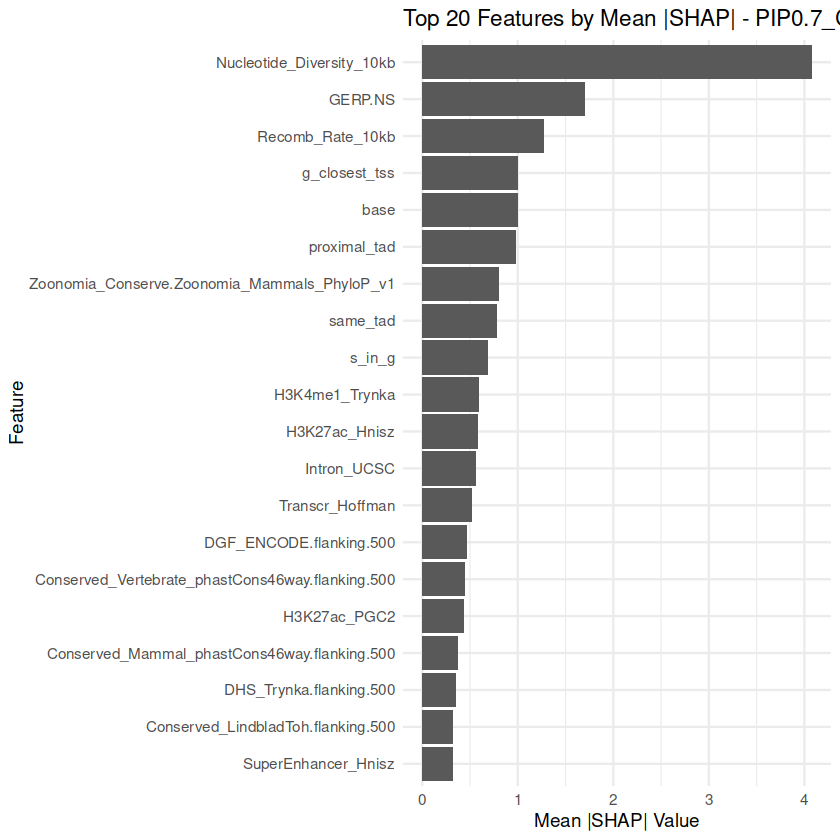

In [21]:
figure_list$PIP0.7_CS0_VCP0.8_COS0$p1

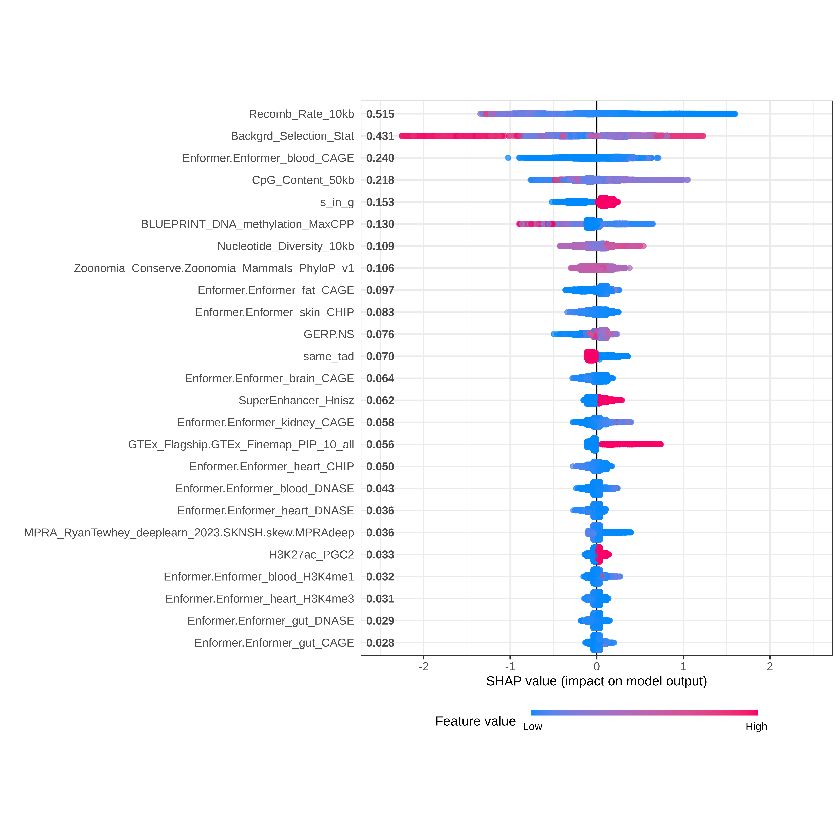

In [23]:
library(png)
library(grid)

img <- readPNG("/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_cv2f/metric/xqtl_feature_max_allcv2f_noxqtl/FunGen_xQTL.PIP0.7_CS0_VCP0.8_COS0.xqtl_feature_max_allcv2f_noxqtl.png")  #FIXME
grid.raster(img)

## (Optional) Experiment 2

### Additional Experiment (Suggestion from Gao)
 only xQTL, kept `g_closest_tss` to make sure we have all same variants, but actually that was removed by below codes
 ```
 pos_feature_tabb_list[[numchr]] = dff[match(intersect(positive_snps, dff$SNP), dff$SNP), -(1:4)]
 neg_feature_tabb_list[[numchr]] = dff[match(intersect(negative_snps, dff$SNP), dff$SNP), -(1:4)]
 
 ```
 
 and for the same reason, all other tests do not have `exon` track. 

experiment by taking out xQTL information from feature sets to check AUC

### prepare new feature sets without xQTL

In [3]:
library(tidyverse)
library(data.table)
setwd('~/deyk/ru/Work/v2f/analysis')
# cv2f_files <- list.files("/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/cv2f_features/cv2f_features/", full.names = T)
# agg_xqtl_files <- list.files("/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max/", full.names = T)


#### Main loop #### 

for(i in 1:22){
  cat(i)
  s2g <- fread(paste0('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max//xqtl_feature_max.', i, '.txt.gz'))
 
  s2g_xqtl_elements <- colnames(s2g) %>% .[str_detect(., 'QTL|qtl|Metabrain|single_context|multi_context')]
  # remove all xqtl feature
  s2g_xqtl <- s2g %>%
    select('CHR','BP','SNP', 'g_closest_tss', any_of(s2g_xqtl_elements))  
  #   %>% 
  # filter(rowSums(select(., any_of(s2g_xqtl_elements))) > 0) 
  # s2g_xqtl %>% mutate(snp=paste0('chr', CHR, ':', BP), rsid=SNP) %>% select(snp, rsid) %>% 
  #   fwrite(paste0('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_allcv2f_xqtlonly_tss/var_list.', i, '.txt'), sep = '\t')
  fwrite(s2g_xqtl, paste0('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_allcv2f_xqtlonly_tss/xqtl_feature_max_allcv2f_xqtlonly_tss.', i, '.txt.gz'), sep = '\t')
    ## the difference with v2f/xqtl_features/no_xqtl_features_v2f is this does not remain the variants in cv2f only and that one does
}



12345678910111213141516171819202122

#### check new feature sets

In [73]:
feat_tmp <- fread('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_allcv2f_xqtlonly_tss/xqtl_feature_max_allcv2f_xqtlonly_tss.22.txt.gz')

In [74]:
s2g_xqtl %>% dim

[1] 90316   252

In [75]:
feat_tmp %>% dim #chrom 22

[1] 90316   252

### Prepare new sets

In [58]:
var_paths <- list.files('/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_allcv2f_xqtlonly_tss/', 'var_list', full.names = T) # the intermediate files from last step
var_paths %>% length

var_list <- data.frame()
for(var_path in var_paths){
    var_list <- rbind(var_list, fread(var_path))
}
fwrite(var_list, '/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_allcv2f_xqtlonly_tss/variant_list.txt.gz', sep = '\t')

[1] 22

In [63]:
var_list %>% head

snp,rsid
<chr>,<chr>
chr1:33092249,rs1000016877
chr1:2106661,rs1000019726
chr1:226392686,rs1000033
chr1:203840605,rs1000050843
chr1:52456463,rs1000057276
chr1:66392232,rs1000085


In [68]:
pos_set <- readLines('/lila/data/deyk/ru/Work/v2f/results/posneg_process/positive_set.PIP0.7_CS0_VCP0.8_COS0.txt')
neg_set <- readLines('/lila/data/deyk/ru/Work/v2f/results/posneg_process/negative_set.PIP0.7_CS0_VCP0.8_COS0.txt')

In [72]:
pos_set %>% length
neg_set %>% length

[1] 1787

[1] 16190725

In [70]:
pos_set[pos_set %in% var_list$rsid] %>% length
neg_set[neg_set %in% var_list$rsid] %>% length

[1] 1594

[1] 4505174

In [ ]:
var_list %>% dim

In [71]:
writeLines(pos_set[pos_set %in% var_list$rsid],'/lila/data/deyk/ru/Work/v2f/results/posneg_process/positive_set.PIP0.7_CS0_VCP0.8_COS0.xqtl_feature_max_allcv2f_xqtlonly_tss.txt')
writeLines(neg_set[neg_set %in% var_list$rsid],'/lila/data/deyk/ru/Work/v2f/results/posneg_process/negative_set.PIP0.7_CS0_VCP0.8_COS0.xqtl_feature_max_allcv2f_xqtlonly_tss.txt')


### submit jobs

In [ ]:
#!/bin/bash

# Parameter sets
param_sets=(
  "PIP0.7_CS0_VCP0.8_COS0"
)

# Feature sets
feature_sets=(
  "/lila/data/deyk/ftp_fgc_xqtl/v2f/xqtl_features/xqtl_features_v2f/agg_snp_max_allcv2f_xqtlonly_tss/xqtl_feature_max_allcv2f_xqtlonly_tss."
)

# Shared input files
bimpath="/home/fengr1/deyk/ftp_fgc_xqtl/v2f/1000G_BIMS_hg38/1000G.EUR.QC."
mafpath="/data/deyk/extras/MAF_features_Aug032022.txt"
ldblockspath="/home/fengr1/deyk/ftp_fgc_xqtl/v2f/LAVA_LDblocks_published.txt"

# Create directories
mkdir -p /home/fengr1/Work/v2f/results/score/FunGen_xQTL
mkdir -p /home/fengr1/Work/v2f/results/metric/FunGen_xQTL
mkdir -p /home/fengr1/Work/v2f/logs

for status in "${param_sets[@]}"; do
  for feat in "${feature_sets[@]}"; do
    feat_label=$(basename ${feat%.*})
    mkdir -p /home/fengr1/Work/v2f/results/score/FunGen_xQTL/${status}/${feat_label}
    mkdir -p /home/fengr1/Work/v2f/results/metric/FunGen_xQTL/${status}/${feat_label}

    positive_set="/lila/data/deyk/ru/Work/v2f/results/posneg_process/positive_set.${status}.txt"
    negative_set="/lila/data/deyk/ru/Work/v2f/results/posneg_process/negative_set.${status}.txt"
    output_metrics="/home/fengr1/Work/v2f/results/metric/FunGen_xQTL/${status}/${feat_label}/FunGen_xQTL.${status}.${feat_label}.metrics"

    echo ">>> Running metrics: $status with $feat_label to $output_metrics"
    Rscript /lila/home/fengr1/codes/cv2f/metric/run_cv2f_MAF5LDmatch_metrics.R \
      --positive_set $positive_set \
      --negative_set $negative_set \
      --feature_file $feat \
      --bimpath $bimpath \
      --mafpath $mafpath \
      --ldblockspath $ldblockspath \
      --output_metrics $output_metrics > /home/fengr1/Work/v2f/logs/xqtl_metric.${status}.${feat_label}.log 2>&1
    echo 'Finished: $output_metrics'
#     for chrm in {1..22}; do
#       output_cv2f="/home/fengr1/Work/v2f/results/score/FunGen_xQTL/${status}/${feat_label}/FunGen_xQTL.GWASonly_response.${status}.${feat_label}.chr${chrm}.cv2f"

#       echo ">>> Running score: $status, $feat_label, chr${chrm}"
#       Rscript /lila/home/fengr1/codes/cv2f/score/run_cv2f_MAF5LDmatch_cv2f_scores.R \
#         --positive_set $positive_set \
#         --negative_set $negative_set \
#         --feature_file $feat \
#         --bimpath $bimpath \
#         --mafpath $mafpath \
#         --ldblockspath $ldblockspath \
#         --output_cv2f $output_cv2f \
#         --chrm $chrm > /home/fengr1/Work/v2f/logs/xqtl_score.${status}.${feat_label}.chr${chrm}.log 2>&1
#     done
  done
done

### Visualization of Results 

In [30]:
library(data.table)
library(ggplot2)
library(dplyr)
library(stringr)

# Define statuses (adjust to match your naming scheme)
statuses <- c("PIP0.7_CS0_VCP0.8_COS0")

# Output folder for plots
#plot_dir <- "/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_cv2f/metric"  
plot_dir <- "/data/analysis_result/cv2f/metric" # path in cloud

dir.create(plot_dir, recursive = TRUE, showWarnings = FALSE)
metric_list = figure_list = list()

for (status in statuses) {
  message("Processing status: ", status)
  
  ### Load metrics
  metric_file <- paste0(plot_dir, "/xqtl_feature_max_allcv2f_xqtlonly_tss/FunGen_xQTL.", status, ".xqtl_feature_max_allcv2f_xqtlonly_tss.metrics")  #FIXME
  shap_file   <- paste0(plot_dir, "/xqtl_feature_max_allcv2f_xqtlonly_tss/FunGen_xQTL.", status, ".xqtl_feature_max_allcv2f_xqtlonly_tss.shap_values.csv")  #FIXME
  
  if (!file.exists(metric_file) | !file.exists(shap_file)) {
    warning("Missing file(s) for status: ", status)
    next
  }
  
  metric_list[[status]] <- fread(metric_file)
  shap_dt <- fread(shap_file)
  
  ### Aggregate SHAP values
  shap_summary <- shap_dt[, .(
    mean_abs_rfvalue = mean(abs(rfvalue)),
    max_rfvalue = max(abs(rfvalue)),
    n = .N
  ), by = variable] %>% 
    arrange(desc(mean_abs_rfvalue))
  
  ### Plot: Top 20 Features
  figure_list[[status]]$p1 <- ggplot(shap_summary[1:20], aes(x = reorder(variable, mean_abs_rfvalue), y = mean_abs_rfvalue)) +
    geom_col() +
    coord_flip() +
    labs(title = paste("Top 20 Features by Mean |SHAP| -", status),
         x = "Feature", y = "Mean |SHAP| Value") +
    theme_minimal()
  
  # ggsave(filename = paste0(plot_dir, "Top20_SHAP_", status, ".png"), plot = p1, width = 10, height = 6)
  
  ### Plot: Top 20 Non-dominant Non-sQTL Features
  figure_list[[status]]$p2 <- shap_summary %>%
    slice(-(1:4)) %>% 
    filter(!str_detect(variable, "sQTL")) %>% 
    slice_max(order_by = mean_abs_rfvalue, n = 20) %>%
    ggplot(aes(x = reorder(variable, mean_abs_rfvalue), y = mean_abs_rfvalue)) +
    geom_col() +
    coord_flip() +
    labs(title = paste("Top 20 Non-dominant Non-sQTL Features -", status),
         x = "Feature", y = "Mean |SHAP| Value") +
    theme_minimal()
  
  # ggsave(filename = paste0(plot_dir, "Top20_NonSQTLSHAP_", status, ".png"), plot = p2, width = 10, height = 6)

}
     

Processing status: PIP0.7_CS0_VCP0.8_COS0



In [31]:
metric_list$PIP0.7_CS0_VCP0.8_COS0

AUROC.mean,AUROC.sd,AUPRC.mean,AUPRC.sd
<dbl>,<dbl>,<dbl>,<dbl>
0.8841824,0.01026659,0.9093274,0.00878147


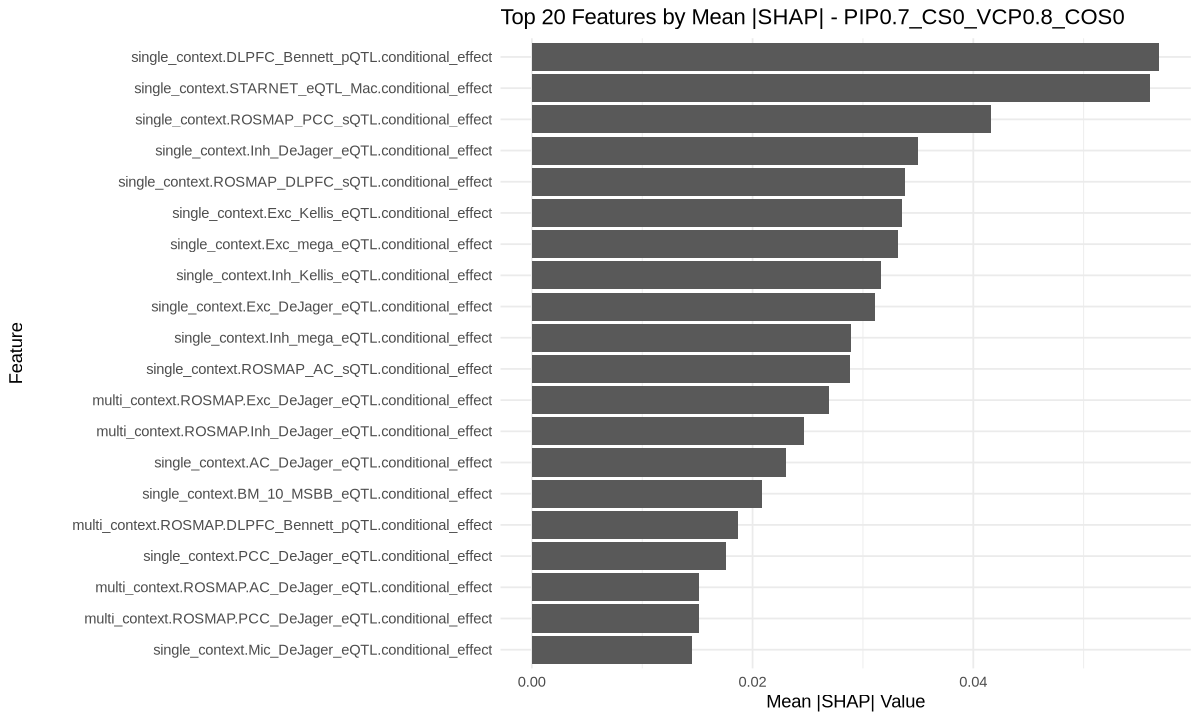

In [32]:
figure_list$PIP0.7_CS0_VCP0.8_COS0$p1

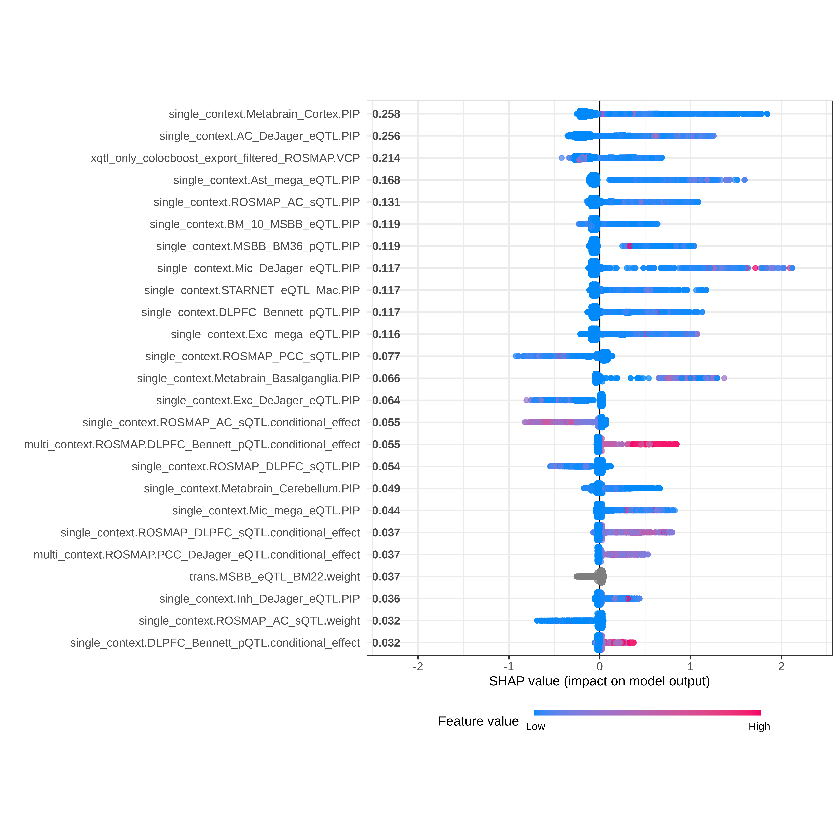

In [8]:
library(png)
library(grid)

#img <- readPNG("/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_cv2f/metric/xqtl_feature_max_allcv2f_xqtlonly_tss/FunGen_xQTL.PIP0.7_CS0_VCP0.8_COS0.xqtl_feature_max_allcv2f_xqtlonly_tss.png")  
img <- readPNG("/data/analysis_result/cv2f/metric/xqtl_feature_max_allcv2f_xqtlonly_tss/FunGen_xQTL.PIP0.7_CS0_VCP0.8_COS0.xqtl_feature_max_allcv2f_xqtlonly_tss.png") # path in cloud

grid.raster(img)

### visualization comparison

In [36]:
#metric_withxqtl <- fread('/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_cv2f/metric/xqtl_feature_max_allcv2f/FunGen_xQTL.PIP0.7_CS0_VCP0.8_COS0.xqtl_feature_max_allcv2f.metrics') 
metric_withxqtl <- fread('/data/analysis_result/cv2f/metric/xqtl_feature_max_allcv2f/FunGen_xQTL.PIP0.7_CS0_VCP0.8_COS0.xqtl_feature_max_allcv2f.metrics')  # path in cloud

#metric_noxqtl <- fread('/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_cv2f/metric/xqtl_feature_max_allcv2f_noxqtl/FunGen_xQTL.PIP0.7_CS0_VCP0.8_COS0.xqtl_feature_max_allcv2f_noxqtl.metrics') 
metric_noxqtl <- fread('/data/analysis_result/cv2f/metric/xqtl_feature_max_allcv2f_noxqtl/FunGen_xQTL.PIP0.7_CS0_VCP0.8_COS0.xqtl_feature_max_allcv2f_noxqtl.metrics')  # path in cloud

#metric_xqtlonly <- fread('/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_cv2f/metric/xqtl_feature_max_allcv2f_xqtlonly_tss/FunGen_xQTL.PIP0.7_CS0_VCP0.8_COS0.xqtl_feature_max_allcv2f_xqtlonly_tss.metrics')
metric_xqtlonly <- fread('/data/analysis_result/cv2f/metric/xqtl_feature_max_allcv2f_xqtlonly_tss/FunGen_xQTL.PIP0.7_CS0_VCP0.8_COS0.xqtl_feature_max_allcv2f_xqtlonly_tss.metrics')  # path in cloud

In [37]:
metric_withxqtl <- melt(metric_withxqtl, measure = patterns(mean = "\\.mean$", sd = "\\.sd$"))
colnames(metric_withxqtl) <- c('Metric', 'Mean', 'SD')
metric_withxqtl$Metric <- c('AUROC', 'AUPRC')

metric_noxqtl <- melt(metric_noxqtl, measure = patterns(mean = "\\.mean$", sd = "\\.sd$"))
colnames(metric_noxqtl) <- c('Metric', 'Mean', 'SD')
metric_noxqtl$Metric <- c('AUROC', 'AUPRC')

metric_xqtlonly <- melt(metric_xqtlonly, measure = patterns(mean = "\\.mean$", sd = "\\.sd$"))
colnames(metric_xqtlonly) <- c('Metric', 'Mean', 'SD')
metric_xqtlonly$Metric <- c('AUROC', 'AUPRC')

metric <- rbind(metric_withxqtl %>% mutate(Set = 'With xQTL'), metric_noxqtl %>% mutate(Set = 'Without xQTL')) %>% rbind(., metric_xqtlonly %>% mutate(Set = 'xQTL only'))

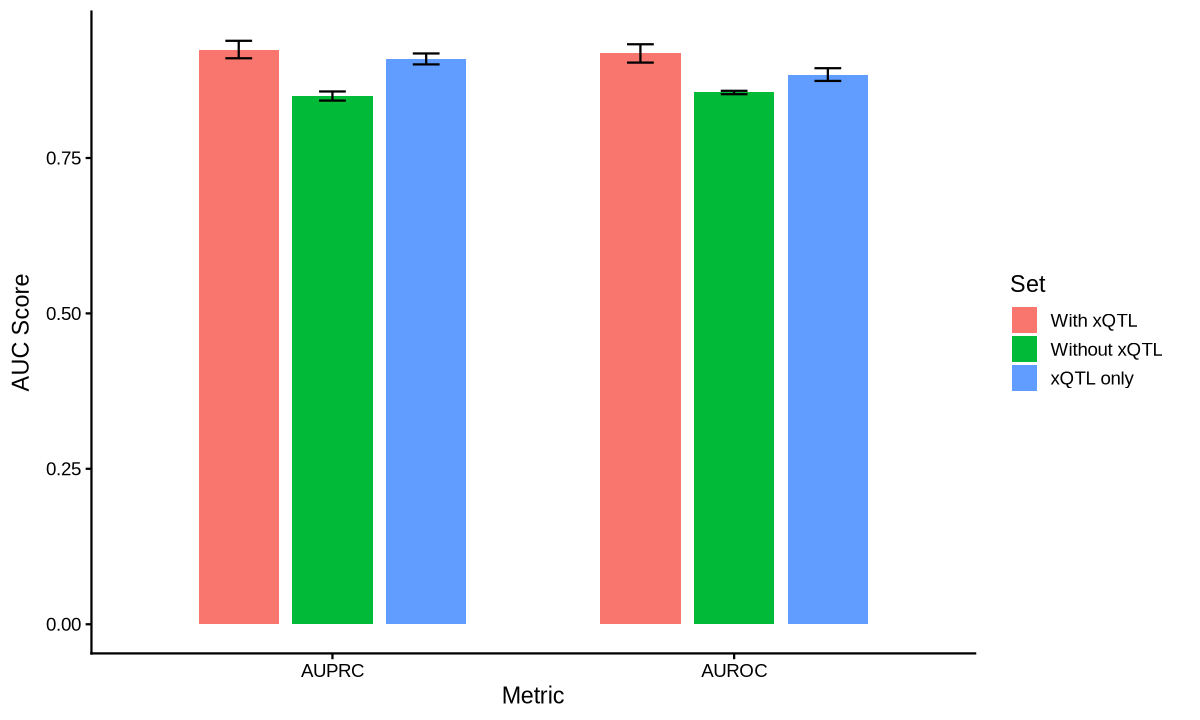

In [38]:
library(data.table)
library(ggplot2)
library(dplyr)
ggplot(metric, aes(x = Metric, y = Mean, fill = Set)) +
  geom_bar(stat = "identity", position = position_dodge(0.7), width = 0.6) +
  geom_errorbar(aes(ymin = Mean - SD, ymax = Mean + SD),
                position = position_dodge(0.7), width = 0.2) +
  labs(y = "AUC Score", x = "Metric") +
  theme_classic(base_size = 14)




### Summary
By including all variants from CS, CoS, and uCoS, along with high-PIP variants (PIP > 0.7) outside the CS, we obtained a positive set of over 1,700 variants.  
The resulting model achieved an AUC of **0.91**, with xQTL features contributing substantially to this performance.  

As a comparative experiment, we removed all xQTL features and trained the model using only Fabiha’s feature set.  
In this setting, the AUC dropped to **0.86**, underscoring the critical contribution of xQTL features to predictive accuracy.

Another a comparative experiment, we kept only all xQTL features and trained the model.  
In this setting, the AUC dropped to **0.88**.